In [1]:
import argparse
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import adjusted_rand_score

import GSG

cmap = cm.get_cmap('tab20')
colors = [cmap(i) for i in range(20)]
def rgba_to_hex(rgba):
    r, g, b, a = rgba
    return '#{:02X}{:02X}{:02X}'.format(int(r*255), int(g*255), int(b*255))
hex_colors1 = [rgba_to_hex(c) for c in colors]

cmap = cm.get_cmap('tab20b')
colors = [cmap(i) for i in range(20)]
def rgba_to_hex(rgba):
    r, g, b, a = rgba
    return '#{:02X}{:02X}{:02X}'.format(int(r*255), int(g*255), int(b*255))
hex_colors2 = [rgba_to_hex(c) for c in colors]
hex_colors = hex_colors1 + hex_colors2

In [2]:
parser = argparse.ArgumentParser(description="GAT")
parser.add_argument("--seeds", type=int, nargs="+", default=[0])
parser.add_argument("--device", type=int, default=1)
parser.add_argument("--warmup_steps", type=int, default=-1)
parser.add_argument("--num_heads", type=int, default=4,
                    help="number of hidden attention heads")
parser.add_argument("--num_out_heads", type=int, default=1,
                    help="number of output attention heads")
parser.add_argument("--residual", action="store_true", default=False,
                    help="use residual connection")
parser.add_argument("--in_drop", type=float, default=0.2,
                    help="input feature dropout")
parser.add_argument("--attn_drop", type=float, default=0.1,
                    help="attention dropout")
parser.add_argument("--weight_decay", type=float, default=2e-4,
                    help="weight decay")
parser.add_argument("--negative_slope", type=float, default=0.2,
                    help="the negative slope of leaky relu for GAT")
parser.add_argument("--drop_edge_rate", type=float, default=0.0)
parser.add_argument("--optimizer", type=str, default="adam")
parser.add_argument("--max_epoch_f", type=int, default=300)
parser.add_argument("--lr_f", type=float, default=0.01, help="learning rate for evaluation")
parser.add_argument("--weight_decay_f", type=float, default=1e-4, help="weight decay for evaluation")
parser.add_argument("--linear_prob", action="store_true", default=True)
parser.add_argument("--load_model", action="store_true")
parser.add_argument("--save_model", action="store_true")
parser.add_argument("--use_cfg", action="store_true")
parser.add_argument("--logging", action="store_true")
parser.add_argument("--scheduler", action="store_true", default=True)
parser.add_argument("--concat_hidden", action="store_true", default=False)

# for graph classification
parser.add_argument("--pooling", type=str, default="mean")
parser.add_argument("--deg4feat", action="store_true", default=False, help="use node degree as input feature")
parser.add_argument("--batch_size", type=int, default=32)

#参数调整
parser.add_argument("--mask_rate", type=float, default=0.3)
parser.add_argument("--encoder", type=str, default="gin")
parser.add_argument("--decoder", type=str, default="gin")
parser.add_argument("--num_hidden", type=int, default=128,
                    help="number of hidden units")
parser.add_argument("--num_layers", type=int, default=3,
                    help="number of hidden layers")
parser.add_argument("--activation", type=str, default="prelu")
parser.add_argument("--max_epoch", type=int, default=850,
                    help="number of training epochs")
parser.add_argument("--lr", type=float, default=0.001 , 
                    help="learning rate")
parser.add_argument("--alpha_l", type=float, default=1, help="`pow`inddex for `sce` loss")
parser.add_argument("--loss_fn", type=str, default="sce")
parser.add_argument("--replace_rate", type=float, default=0.05)
parser.add_argument("--norm", type=str, default="batchnorm")

# GSG专属参数
parser.add_argument("--feature_dim_method", type=str, default="PCA")
parser.add_argument("--num_features", type=int, default=600)
parser.add_argument("--threshold_radius", type=int, default=22)
parser.add_argument("--folder_name", type=str, default="/home/sunhang/Embedding/Spatial_dataset/10X/")
parser.add_argument("--sample_name", type=str, default="151673")
parser.add_argument("--cluster_label", type=str, default= "cluster")
parser.add_argument("--num_classes", type=int, default=7, help = "The number of clusters")

# 读取参数
args = parser.parse_args(args=[])
print(args)

Namespace(activation='prelu', alpha_l=1, attn_drop=0.1, batch_size=32, cluster_label='cluster', concat_hidden=False, decoder='gin', deg4feat=False, device=1, drop_edge_rate=0.0, encoder='gin', feature_dim_method='PCA', folder_name='/home/sunhang/Embedding/Spatial_dataset/10X/', in_drop=0.2, linear_prob=True, load_model=False, logging=False, loss_fn='sce', lr=0.001, lr_f=0.01, mask_rate=0.3, max_epoch=850, max_epoch_f=300, negative_slope=0.2, norm='batchnorm', num_classes=7, num_features=600, num_heads=4, num_hidden=128, num_layers=3, num_out_heads=1, optimizer='adam', pooling='mean', replace_rate=0.05, residual=False, sample_name='151673', save_model=False, scheduler=True, seeds=[0], threshold_radius=22, use_cfg=False, warmup_steps=-1, weight_decay=0.0002, weight_decay_f=0.0001)


In [3]:
adata = sc.read_h5ad('/home/sunhang/Embedding/Spatial_dataset/slideseqv2/slideseqv2.h5ad')
num_classes = adata.obs[args.cluster_label].nunique()
adata, graph = GSG.Graph_10X(adata, args)
adata, model = GSG.GSG_train(adata, graph, args)

100%|██████████| 139432/139432 [00:00<00:00, 492072.42it/s]
2026-01-17 20:05:37,922 - INFO - start training..
# Epoch 849: train_loss: 0.7259: 100%|██████████| 850/850 [00:42<00:00, 19.96it/s]


In [4]:
adata.obs["GSG_Kmeans_cluster"] = GSG.KMeans_use(adata.obsm["GSG_embedding"], num_classes)
adata.obs["GSG_Kmeans_cluster_str"] = adata.obs["GSG_Kmeans_cluster"].astype(str)
ari = adjusted_rand_score(adata.obs['cluster'].values, adata.obs['GSG_Kmeans_cluster_str'])
print(ari)

0.10155287728848736


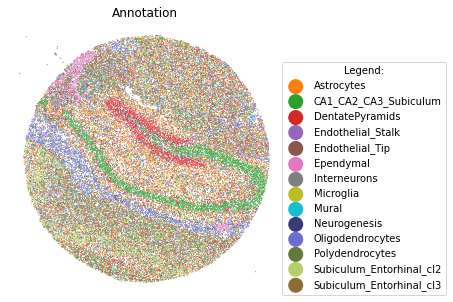

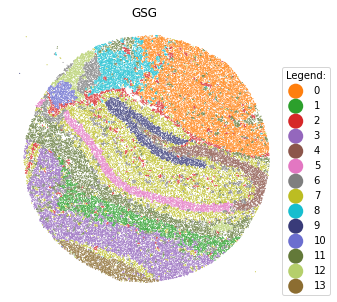

In [7]:
spatial = adata.obsm['spatial']
cell_type = adata.obs['cluster'].values
cell_type_unique = np.unique(cell_type)
plt.figure(figsize=(5, 5))
for i in range(cell_type_unique.shape[0]):
    selection = cell_type == cell_type_unique[i]
    plt.scatter(spatial[selection, 0], spatial[selection, 1], c=hex_colors[2*i+2], s=4, marker='.', edgecolors='none', label=cell_type_unique[i])
plt.gca().set_aspect('equal')
plt.axis('off')
plt.title('Annotation')
plt.legend(title='Legend:', loc=(1, 0), markerscale=15)
plt.show()


spatial = adata.obsm['spatial']
cell_type = adata.obs['GSG_Kmeans_cluster'].values
cell_type_unique = np.unique(cell_type)
plt.figure(figsize=(5, 5))
for i in range(cell_type_unique.shape[0]):
    selection = cell_type == cell_type_unique[i]
    plt.scatter(spatial[selection, 0], spatial[selection, 1], c=hex_colors[2*i+2], s=4, marker='.', edgecolors='none', label=cell_type_unique[i])
plt.gca().set_aspect('equal')
plt.axis('off')
plt.title('GSG')
plt.legend(title='Legend:', loc=(1, 0), markerscale=15)
plt.show()